In [1]:
'''
@File    :   thend.ipynb
@Time    :   2023/07/23 14:57:22
@Author  :   Ravi K.
@Desc    :   A notebook for testing combination of everything we have done.
'''

'\n@File    :   thend.ipynb\n@Time    :   2023/07/23 14:57:22\n@Author  :   Ravi K.\n@Desc    :   A notebook for testing combination of everything we have done.\n'

In [2]:
import final_script as fs
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.stats import skewnorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'figure.dpi':150,    
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [3]:
snr, outliers, grb_mask, grb_snr = fs.find_grb("/home/ravioli/astro/ksp/grb/GRB190928A/1s", 307372337.0, 2)[0]

Master light curve already exists at /home/ravioli/astro/ksp/grb/GRB190928A/1s/master_lc
Requested energy bins already exist at /home/ravioli/astro/ksp/grb/GRB190928A/1s/3_bins


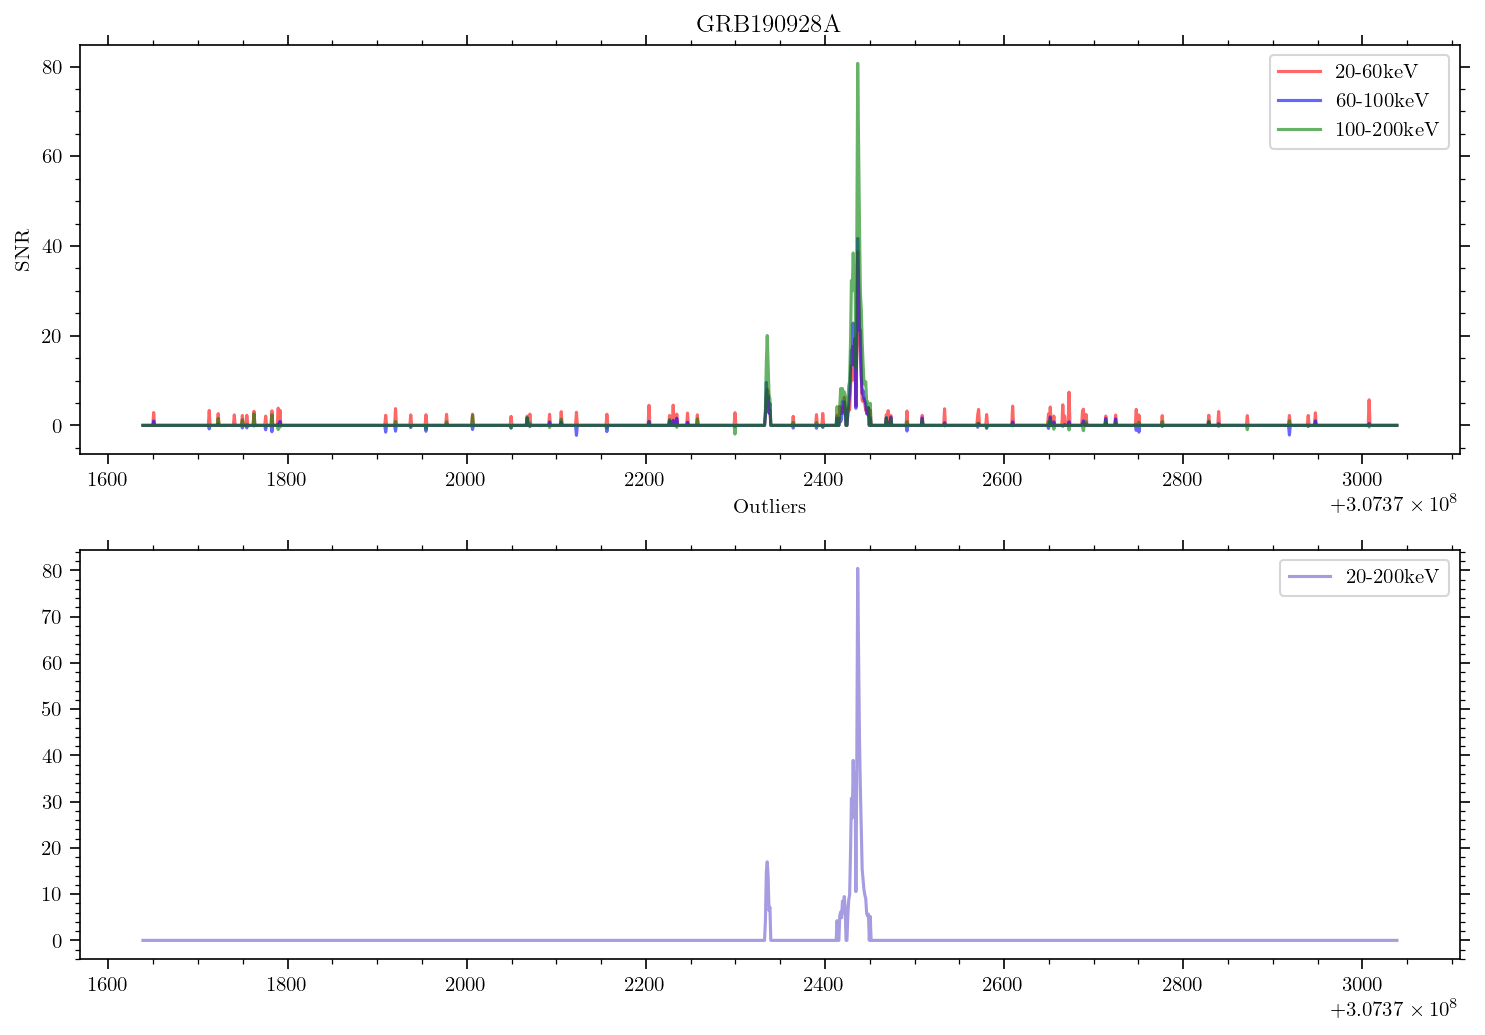

In [4]:
t, *_ = fs.quadratic_detrend_trigger("/home/ravioli/astro/ksp/grb/GRB190928A/1s/3_bins/20-60/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc", 1702)
grb = np.zeros_like(t['RATE'])
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
grb[outliers] = snr[0]
plt.plot(t['TIME'], grb, alpha=0.6, color='red', label='20-60keV')
grb[outliers] = snr[1]
plt.plot(t['TIME'], grb, alpha=0.6, color='blue', label='60-100keV')
grb[outliers] = snr[2]
plt.plot(t['TIME'], grb, alpha=0.6, color='green', label='100-200keV')
plt.title("GRB190928A")
plt.xlabel("Outliers")
plt.ylabel("SNR")
plt.legend()
plt.subplot(2,1,2)
grb[outliers] = 0
grb[outliers[grb_mask]] = grb_snr
plt.plot(t['TIME'], grb, alpha=0.6, color='slateblue', label='20-200keV')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
snr, outliers, grb_mask, grb_snr = fs.find_grb("/home/ravioli/astro/ksp/grb/GRB210709A/1s", 363502145.0, 2.5)[0]

Master light curve already exists at /home/ravioli/astro/ksp/grb/GRB210709A/1s/master_lc
Requested energy bins already exist at /home/ravioli/astro/ksp/grb/GRB210709A/1s/3_bins


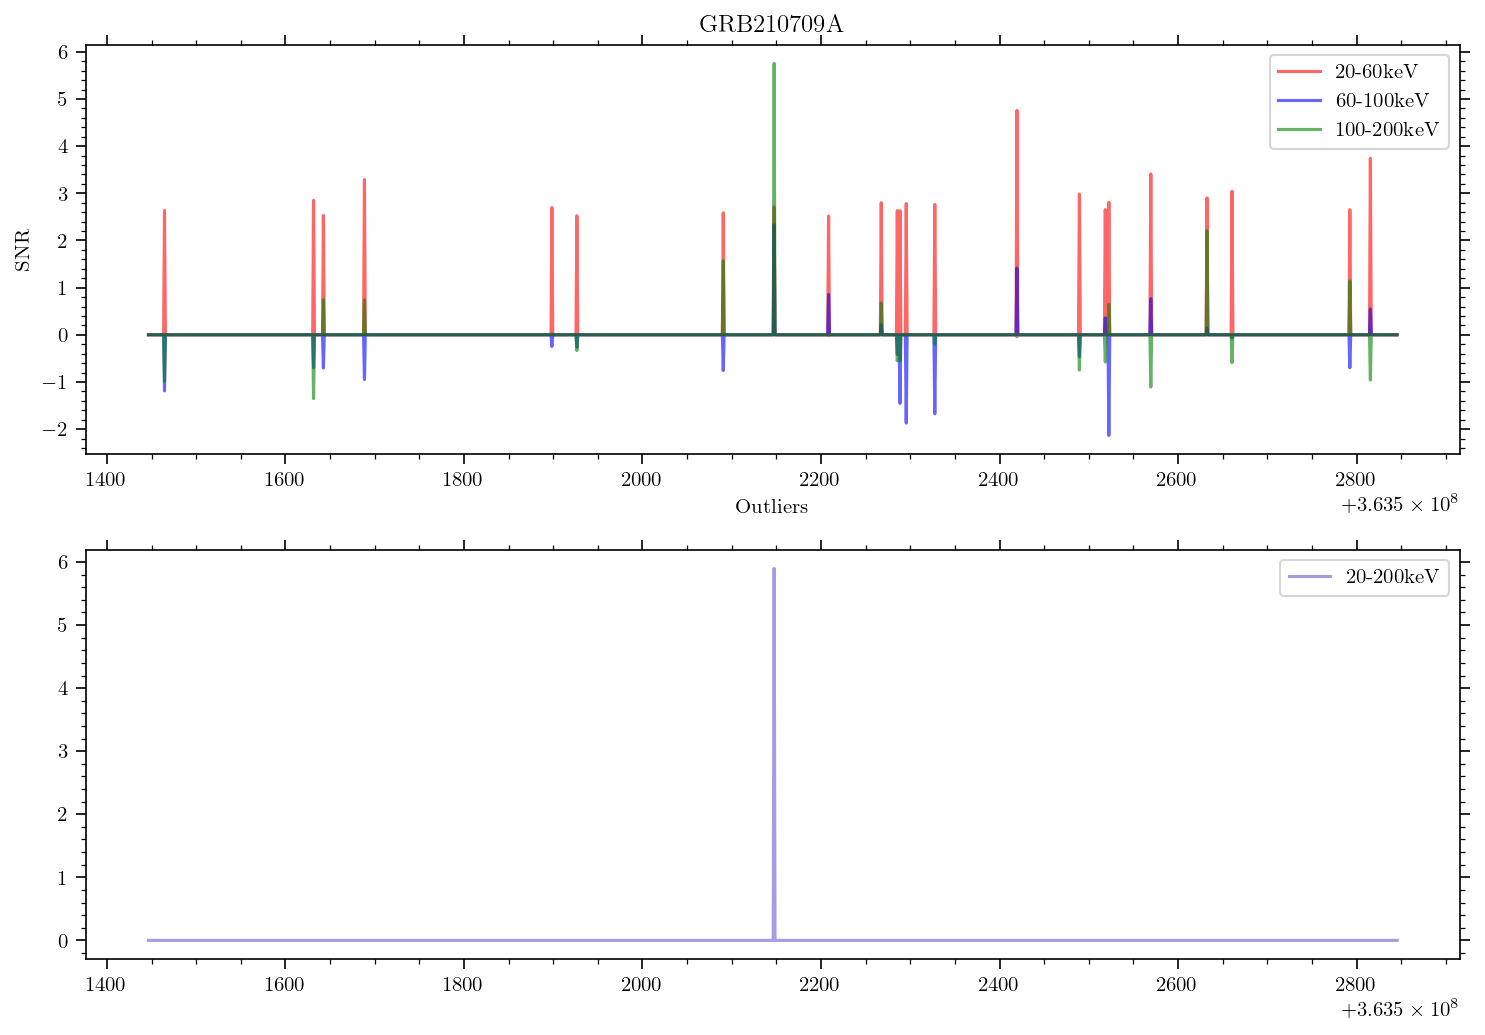

In [6]:
detrended, raw, trend, *_ = fs.quadratic_detrend_trigger("/home/ravioli/astro/ksp/grb/GRB210709A/1s/3_bins/20-60/AS1A10_073T02_9000004522_31247cztM0_level2_quad_clean_Q0.lc", 3513)
grb = np.zeros_like(detrended['RATE'])
plt.figure(figsize=(10,7), dpi=150)
plt.subplot(2,1,1)
grb[outliers] = snr[0]
plt.plot(detrended['TIME'], grb, alpha=0.6, color='red', label='20-60keV')
grb[outliers] = snr[1]
plt.plot(detrended['TIME'], grb, alpha=0.6, color='blue', label='60-100keV')
grb[outliers] = snr[2]
plt.plot(detrended['TIME'], grb, alpha=0.6, color='green', label='100-200keV')
plt.title("GRB210709A")
plt.xlabel("Outliers")
plt.ylabel("SNR")
plt.legend()
plt.subplot(2,1,2)
grb[outliers] = 0
grb[outliers[grb_mask]] = grb_snr
plt.plot(detrended['TIME'], grb, alpha=0.6, color='slateblue', label='20-200keV')
plt.legend()
plt.tight_layout()
plt.show()

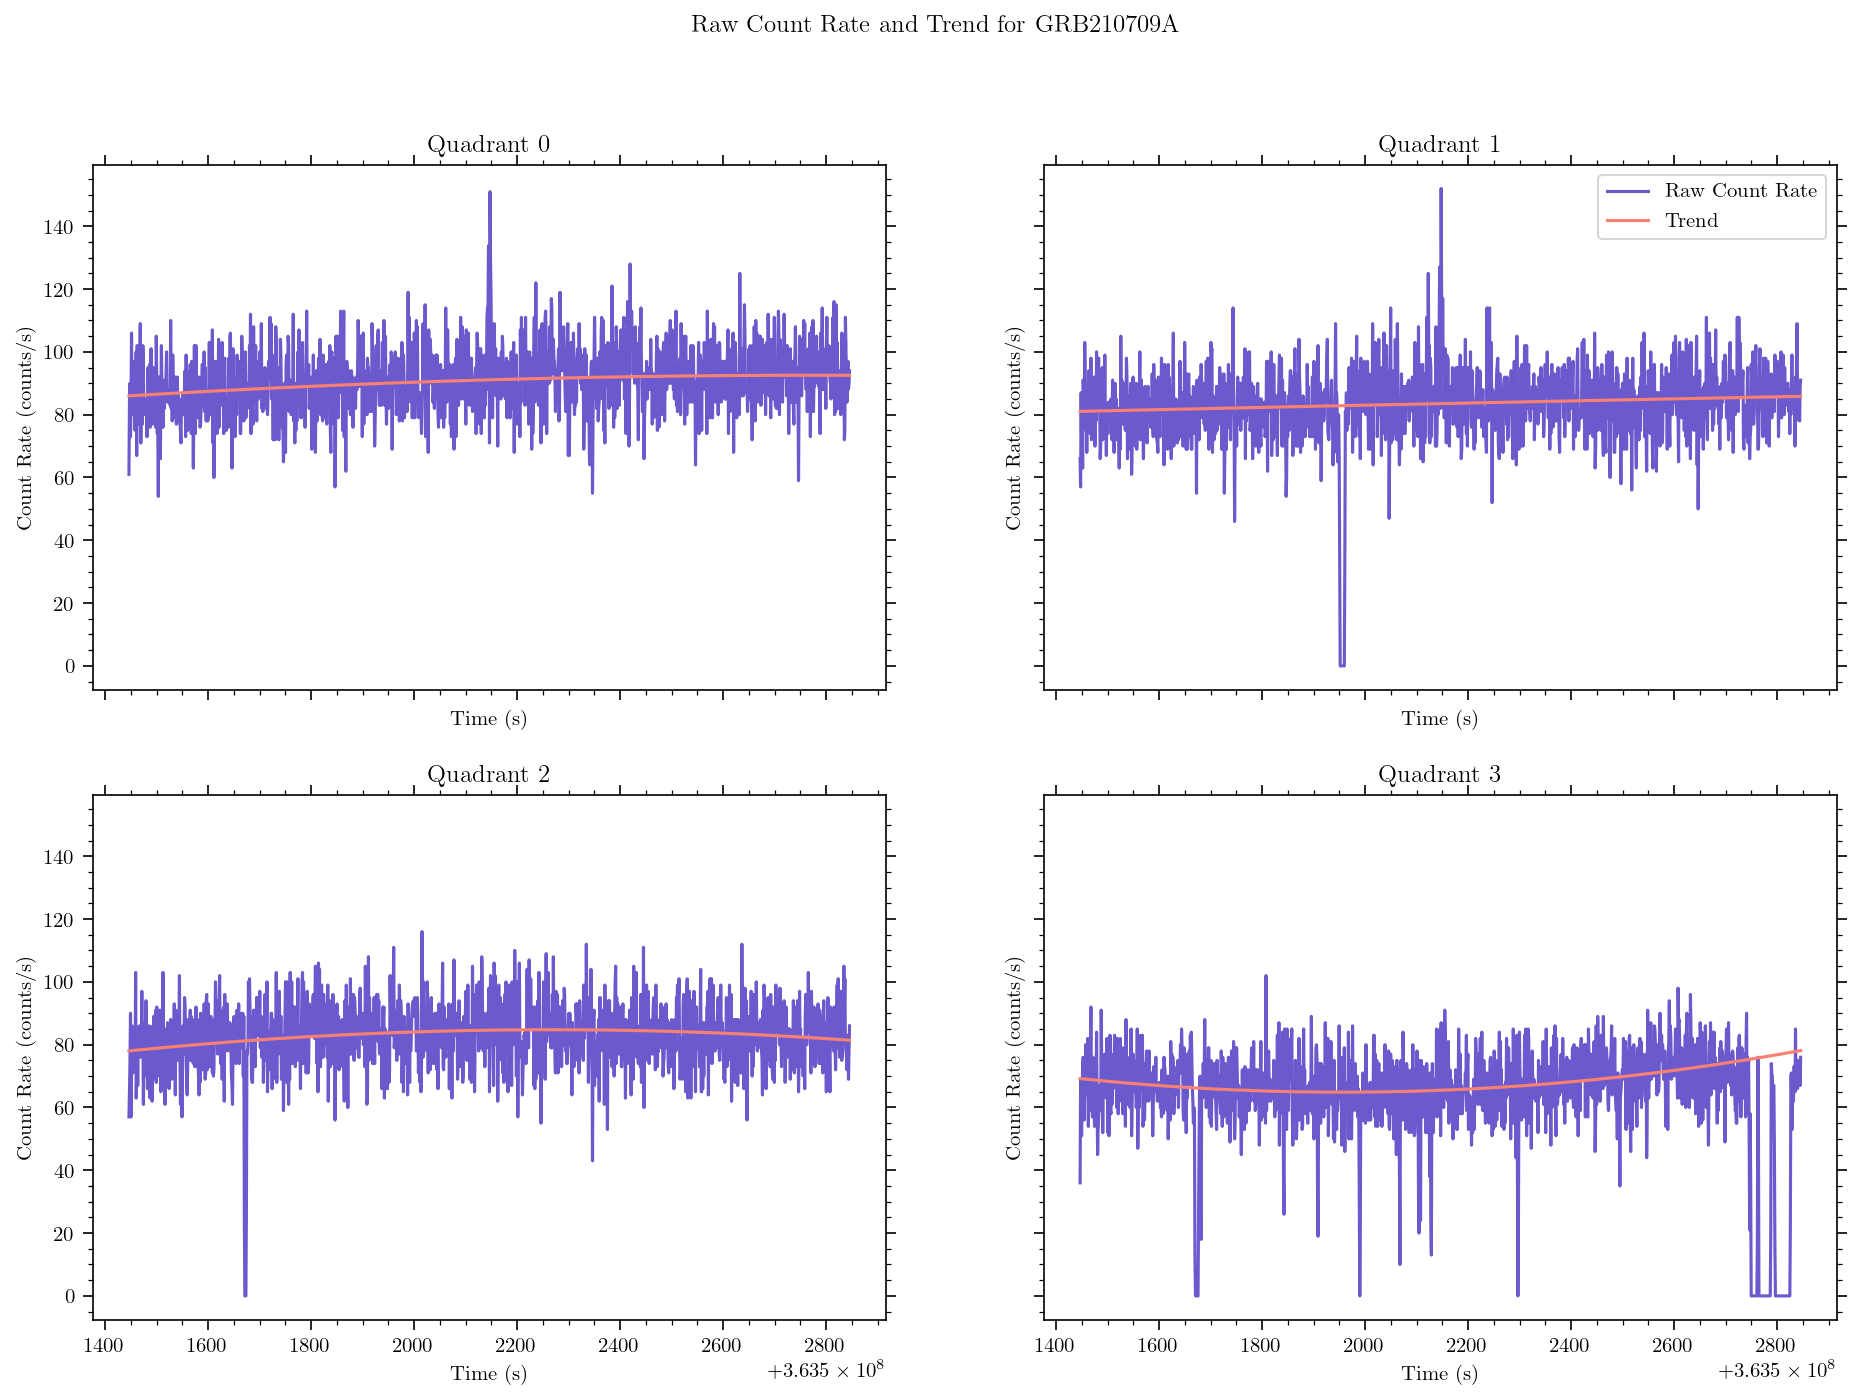

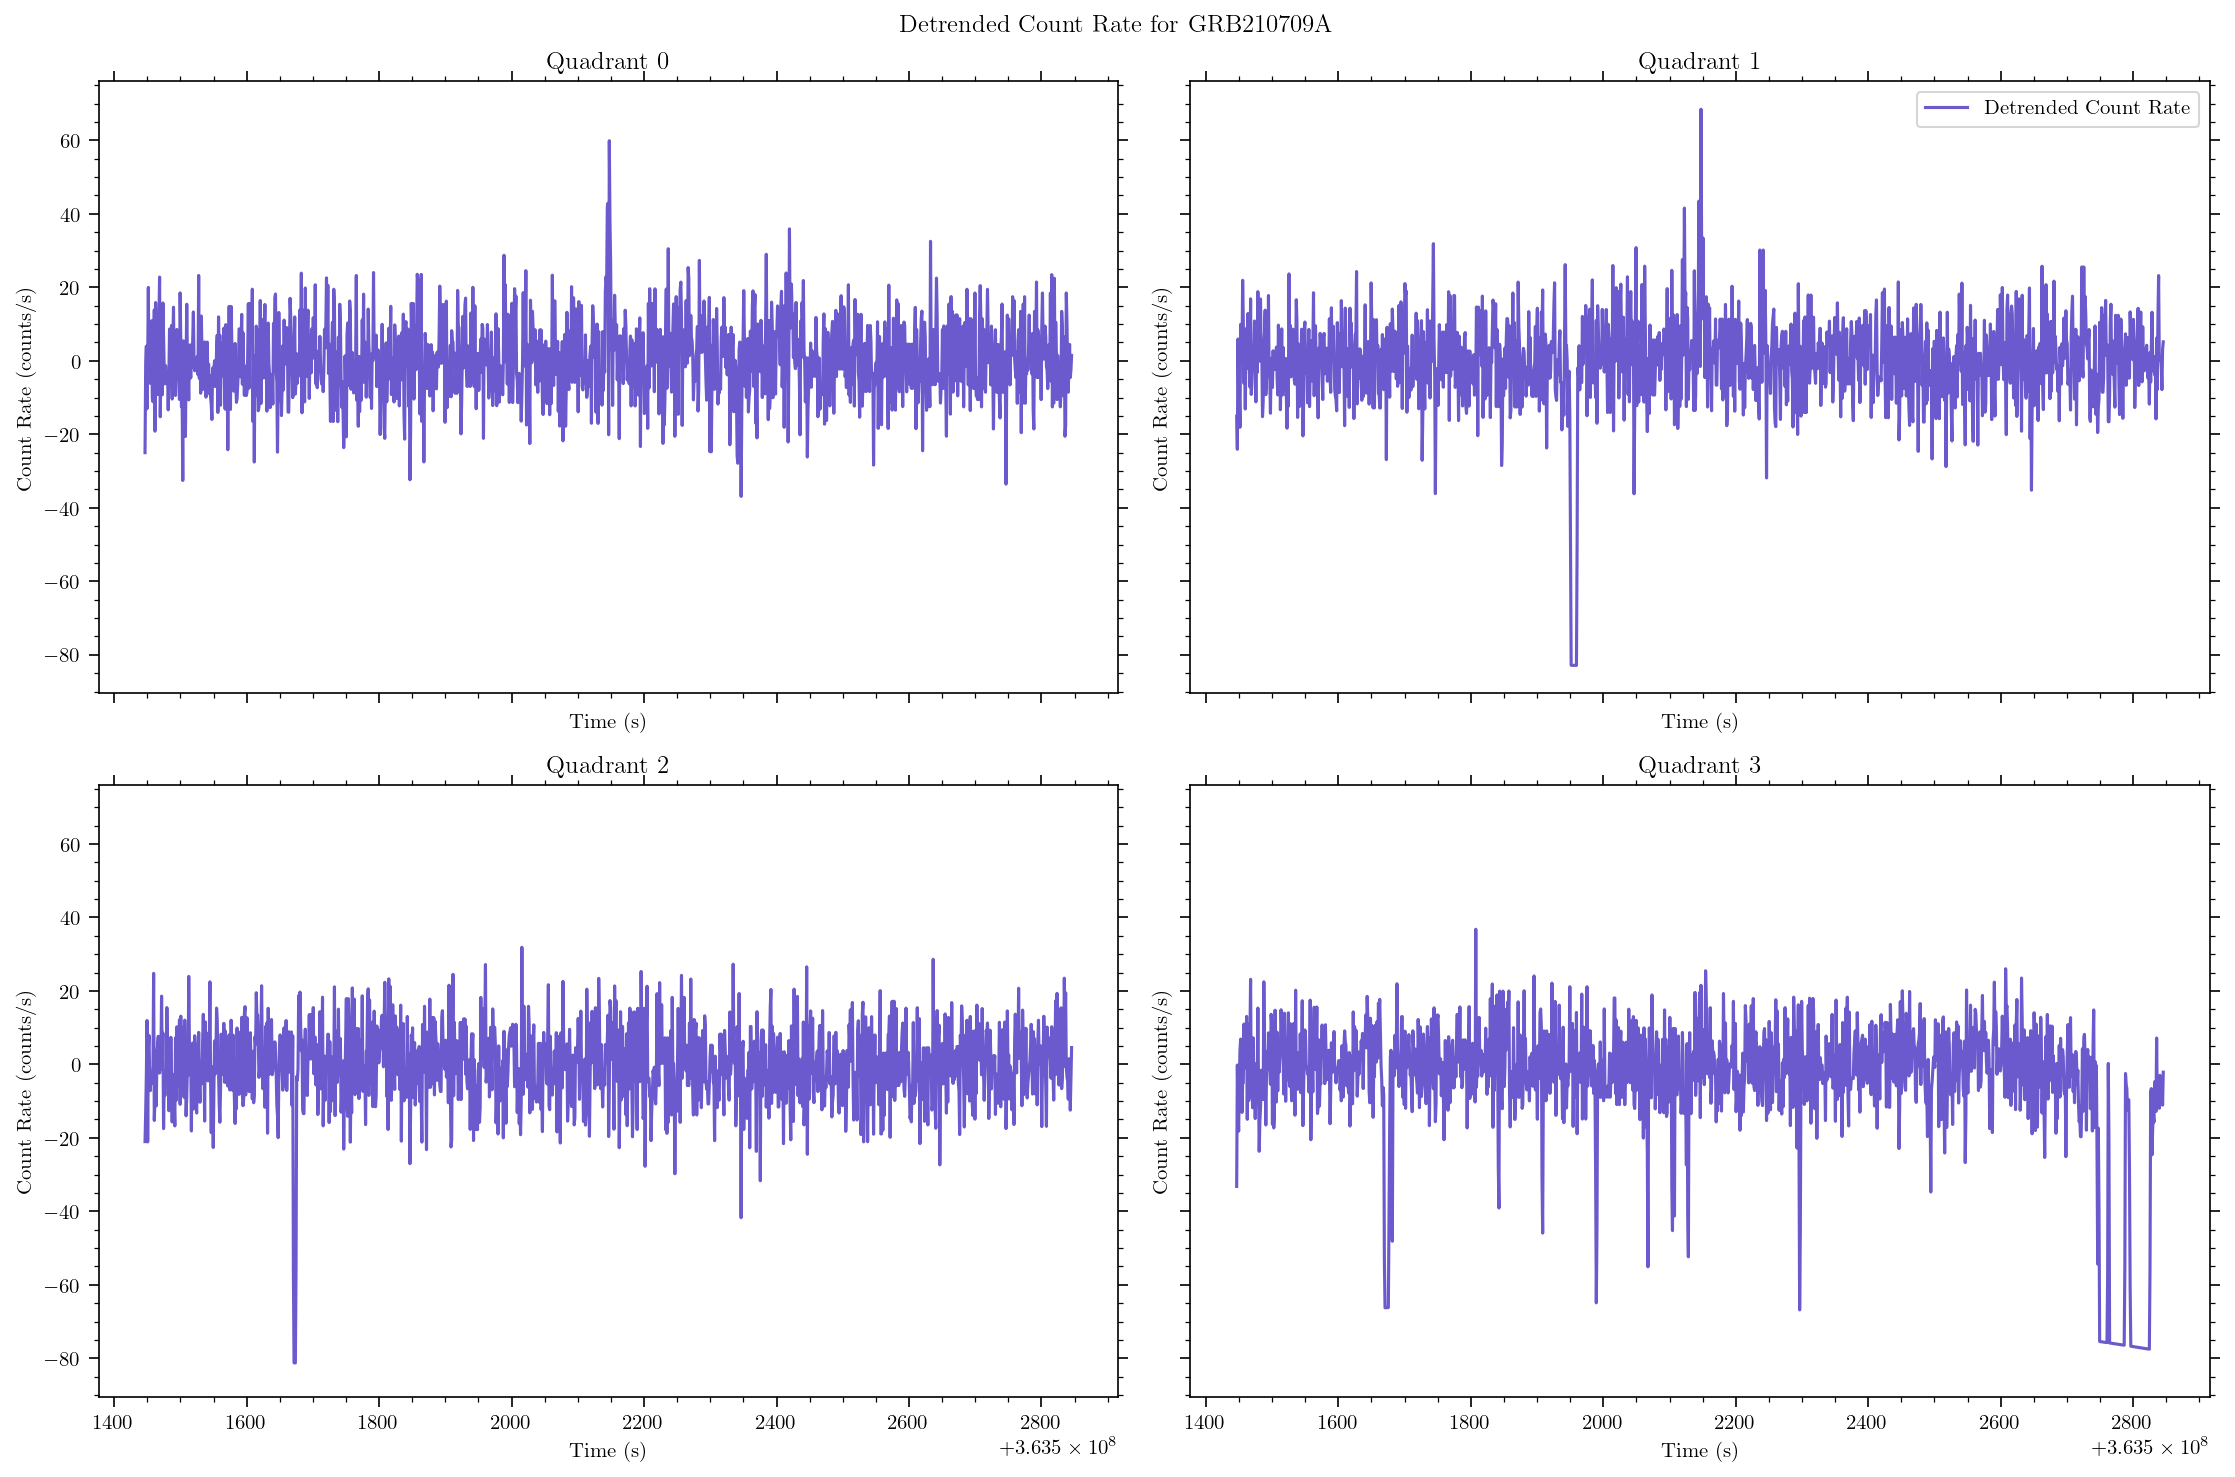

In [14]:
fig_raw, ax_raw = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
master_lcs = np.sort(glob.glob("/home/ravioli/astro/ksp/grb/GRB210709A/1s/master_lc/*.lc"))
for i in range(4):
    detrended, raw, trend, _, popt = fs.quadratic_detrend_trigger(master_lcs[i], 3513, polyorder=2)
    ax_raw[i//2, i%2].plot(raw['TIME'], raw['RATE'], color='slateblue', label='Raw Count Rate')
    ax_raw[i//2, i%2].plot(raw['TIME'], trend, color='salmon', label='Trend')
    ax_raw[i//2, i%2].set_xlabel("Time (s)")
    ax_raw[i//2, i%2].set_ylabel("Count Rate (counts/s)")
    ax_raw[i//2, i%2].set_title("Quadrant {}".format(i))
    if i == 1:
        ax_raw[i//2, i%2].legend()
fig_raw.suptitle("Raw Count Rate and Trend for GRB210709A")

fig_detrended, ax_detrended = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
for i in range(4):
    detrended, raw, trend, _, popt = fs.quadratic_detrend_trigger(master_lcs[i], 3513, polyorder=2)
    ax_detrended[i//2, i%2].plot(detrended['TIME'], detrended['RATE'], color='slateblue', label='Detrended Count Rate')
    ax_detrended[i//2, i%2].set_xlabel("Time (s)")
    ax_detrended[i//2, i%2].set_ylabel("Count Rate (counts/s)")
    ax_detrended[i//2, i%2].set_title("Quadrant {}".format(i))
    if i == 1:
        ax_detrended[i//2, i%2].legend()
fig_detrended.suptitle("Detrended Count Rate for GRB210709A")
plt.tight_layout()